Install Dependencies

In [2]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.2 MB/s eta 0:00:00


Import necessary libraries and set up paths

In [3]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
import tensorflow as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetB0
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from keras_tuner.tuners import RandomSearch
import matplotlib.pyplot as plt

Set up data generators

In [4]:
# Define data paths
train_dir = '/content/drive/MyDrive/Colab Notebooks/data/Training'
test_dir = '/content/drive/MyDrive/Colab Notebooks/data/Testing'

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2  # Validation split
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


Define the model

In [5]:
def create_model(learning_rate=0.001, dropout_rate=0.5):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Set up reinforcement learning elements

In [6]:
class CustomCallback(Callback):
    def __init__(self, model, env):
        self.model = model
        self.env = env

    def on_epoch_end(self, epoch, logs=None):
        reward = self.env.step()  # Custom environment step
        # Incorporate reward into training process
        print(f'Epoch {epoch+1}: Reward {reward}')

Hyperparameter tuning using Keras Tuner

In [8]:
def build_model(hp):
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    dropout_rate = hp.Choice('dropout_rate', [0.3, 0.4, 0.5])
    return create_model(learning_rate, dropout_rate)

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='brain_tumour_classification'
)

tuner.search_space_summary()

# Perform the search
tuner.search(train_generator, epochs=1, validation_data=validation_generator)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'Best hyperparameters: {best_hps.values}')

Trial 5 Complete [00h 10m 16s]
val_accuracy: 0.26321940620740253

Best val_accuracy So Far: 0.2713993589083354
Total elapsed time: 01h 06m 45s
Best hyperparameters: {'learning_rate': 0.01, 'dropout_rate': 0.3}


Train the model with reinforcement learning elements

In [9]:
# Build the model with the optimal hyperparameters
model = build_model(best_hps)

# Custom environment for reinforcement learning
class CustomEnv:
    def step(self):
        # Define custom reward mechanism
        return np.random.rand()  # Example reward

env = CustomEnv()

# Train the model with custom callback
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[CustomCallback(model, env)]
)

Epoch 1/5
143/143 [==============================] - 196s 1s/step - loss: 1.7735 - accuracy: 0.2665 - val_loss: 1.3837 - val_accuracy: 0.2796
Epoch 2/5
143/143 [==============================] - 187s 1s/step - loss: 1.3867 - accuracy: 0.2767 - val_loss: 1.3834 - val_accuracy: 0.2796
Epoch 3/5
143/143 [==============================] - 182s 1s/step - loss: 1.3844 - accuracy: 0.2787 - val_loss: 1.3838 - val_accuracy: 0.2796
Epoch 4/5
143/143 [==============================] - 183s 1s/step - loss: 1.3843 - accuracy: 0.2730 - val_loss: 1.3838 - val_accuracy: 0.2796
Epoch 5/5
143/143 [==============================] - 181s 1s/step - loss: 1.3847 - accuracy: 0.2792 - val_loss: 1.3834 - val_accuracy: 0.2796


Evaluate the model

In [10]:
# Evaluate the model on the test data
results = model.evaluate(test_generator)
print(f'Test loss: {results[0]}')
print(f'Test accuracy: {results[1]}')

41/41 [==============================] - 341s 8s/step - loss: 1.3798 - accuracy: 0.3089
Test loss: 1.3798054456710815
Test accuracy: 0.30892449617385864


Plot the training history

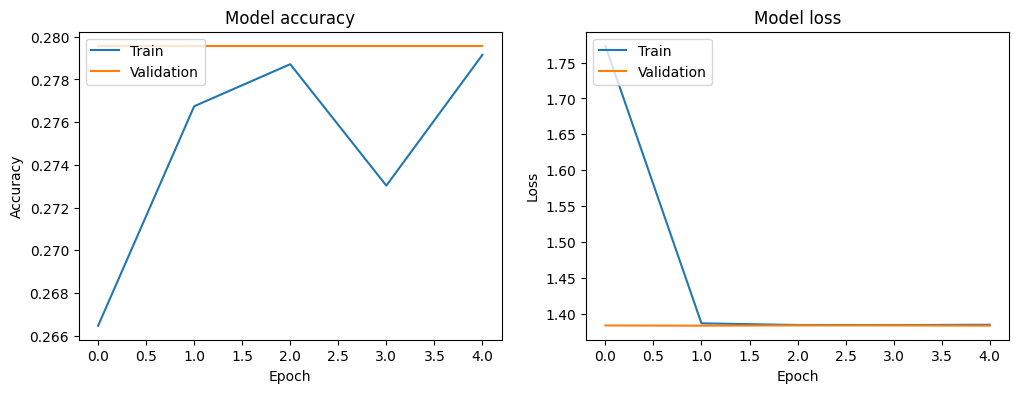

In [11]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Displaying the confusion matrix and classification report

41/41 [==============================] - 57s 1s/step


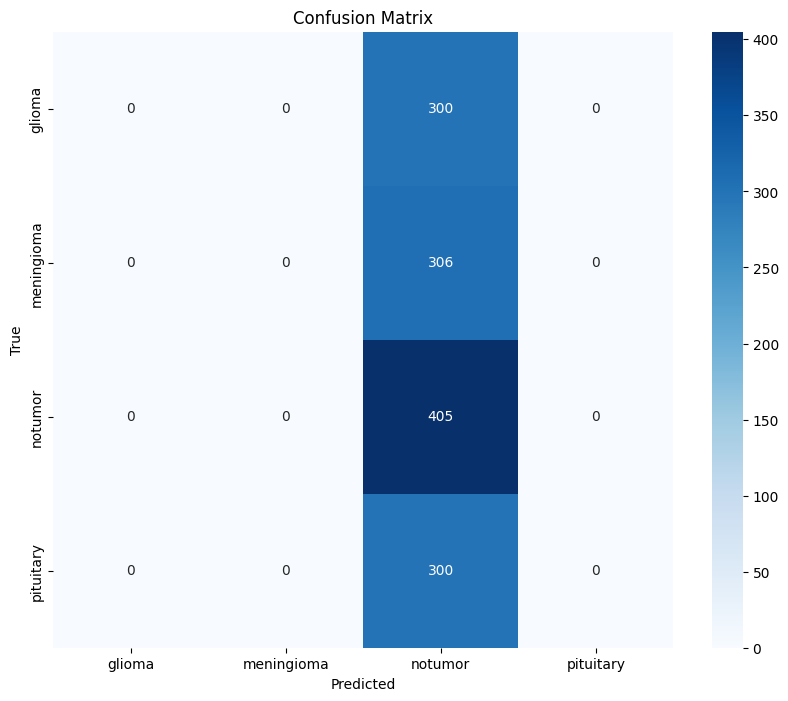

Classification Report
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       300
  meningioma       0.00      0.00      0.00       306
     notumor       0.31      1.00      0.47       405
   pituitary       0.00      0.00      0.00       300

    accuracy                           0.31      1311
   macro avg       0.08      0.25      0.12      1311
weighted avg       0.10      0.31      0.15      1311



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the labels for the test data
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get the true labels
y_true = test_generator.classes

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
print('Classification Report')
target_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))